# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, rand_score, adjusted_rand_score
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
from sklearn.metrics.cluster import homogeneity_score, contingency_matrix

# Data 

In [2]:
# read .mat files
train = sio.loadmat('data/train_32x32.mat')
test = sio.loadmat('data/test_32x32.mat')
# extract data and labels
train_data: np.ndarray = train['X']
train_labels: np.ndarray = train['y']
test_data: np.ndarray = test['X']
test_labels: np.ndarray = test['y']

# Data reshape and sampling

In [3]:
trd_reshape = train_data.reshape(3072, train_data.shape[3]).T
ted_reshape = test_data.reshape(3072, test_data.shape[3]).T
zipped = list(zip(trd_reshape, train_labels))
np.random.shuffle(zipped)
srt = sorted(zipped, key=lambda x: x[1])
out = []
old_labels = []
x = -1
for i, q in enumerate(srt):
  if q[1] != x:
    # New label
    out += list(map(lambda w: w[0], srt[i:i+2500]))
    old_labels += list(map(lambda w: w[1], srt[i:i+2500]))
    x = q[1]

trd_new = out
labels = list(map(lambda x: x[0], old_labels))
labels = np.array(labels)
# labels

# Question 1

## Perform PCA

In [4]:
def train_pca(i) -> (PCA, np.ndarray, np.ndarray):
    pca = PCA(n_components=i)
    pca.fit(trd_new)
    train_data_pca = pca.transform(trd_new)
    test_data_pca = pca.transform(ted_reshape)
    return pca, train_data_pca, test_data_pca


### Get dimiensions for 0.9 PoV

In [5]:
pca, tr, te = train_pca(3072)

### Plot the PoV

PoV = 0.900 > 0.9 achieved at 26 dimensions


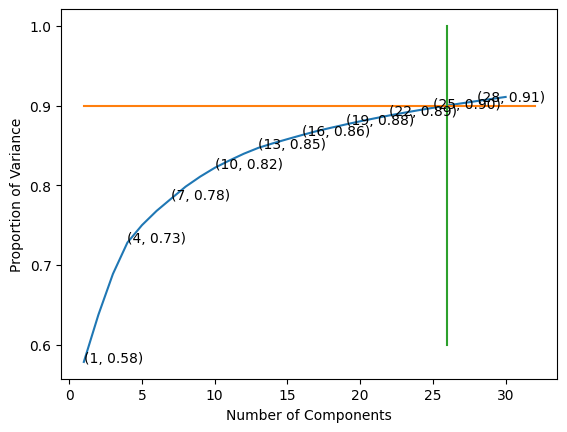

In [7]:
cum = np.cumsum(pca.explained_variance_ratio_)

q = cum[:30]
plt.plot(range(1, 31), q)
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance') #for each component
v = 0
for i in range(1, 31, 3):
    plt.annotate(f'({i}, {q[i-1]:.2f})', (i, q[i-1]))
    if q[i-1] >= 0.9:
        v = i
        break

plt.plot(np.linspace(1, 32, 320), [0.9] * 320)
plt.plot([v - 2] * 320, np.linspace(0.6, 1.0, 320))
print(f'PoV = {q[25]:.3f} > 0.9 achieved at {v - 2} dimensions')
plt.show()

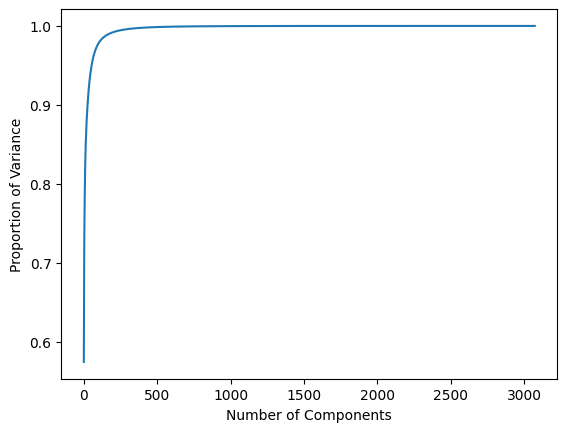

In [44]:
plt.plot(cum)
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance')
plt.show()

In [8]:
_, tr_pca_1, te_pca_1 = train_pca(v - 2)
pca2, tr_pca_2, te_pca_2 = train_pca(10)

In [20]:
tr_pca_1.shape, te_pca_1.shape, tr_pca_2.shape, te_pca_2.shape

((25000, 26), (26032, 26), (25000, 10), (26032, 10))

## Visualise PCA components

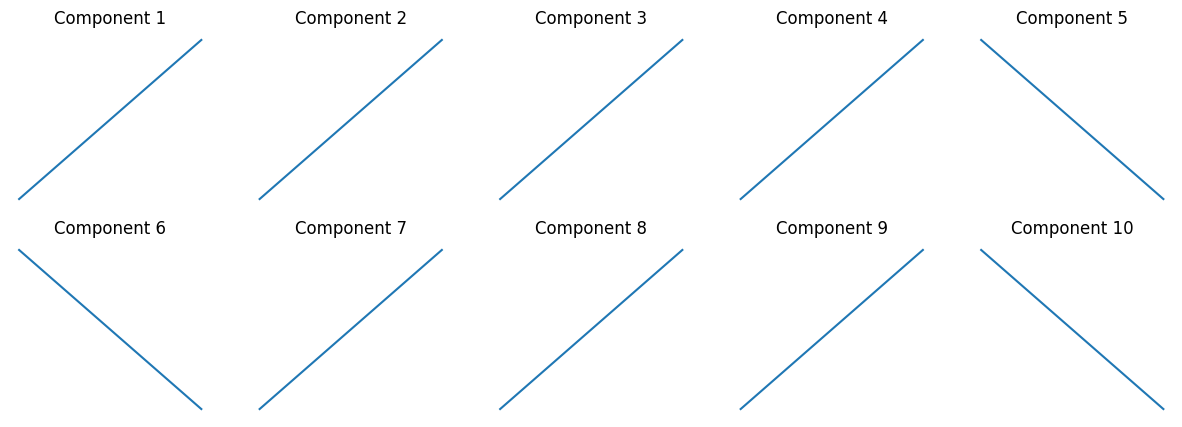

In [28]:
# visualise top ten eigenvectors
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(2):
    for j in range(5):
        ax[i, j].plot(pca2.components_[i * 5 + j][:2])
        ax[i, j].set_title(f'Component {i * 5 + j + 1}')
        ax[i, j].axis('off')
plt.show()

In [23]:
imgs = pca2.inverse_transform(tr_pca_2)[:10].reshape(10, 32, 32, 3)
fig = px.imshow(imgs, facet_col=0, facet_col_wrap=5, labels={'facet_col': 'Principal Component'}, title='Principal Components')
fig.show()


## Perform kNN classification

In [48]:
def knn(k) -> (float, float, float):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(trd_new, labels)
    x = accuracy_score(test_labels, knn.predict(ted_reshape))
    knn.fit(tr_pca_1, labels)
    y = accuracy_score(test_labels, knn.predict(te_pca_1))
    knn.fit(tr_pca_2, labels)
    z = accuracy_score(test_labels, knn.predict(te_pca_2))
    print(f'k = {k}:\n\tAccuracy on original data: {x:.3f}\n\tAccuracy on PCA data (PoV = 0.9): {y:.3f}\n\tAccuracy on PCA data (10 dimensions): {z:.3f}')

knn(5) 
print()
knn(7)

k = 5:
	Accuracy on original data: 0.407
	Accuracy on PCA data (PoV = 0.9): 0.403
	Accuracy on PCA data (10 dimensions): 0.255

k = 7:
	Accuracy on original data: 0.416
	Accuracy on PCA data (PoV = 0.9): 0.411
	Accuracy on PCA data (10 dimensions): 0.258


In [49]:
# np.savetxt('tr_pca_2.csv', tr_pca_1, delimiter=',') # The dimensions = 10 dataset.

# Question 2

In [50]:
# scale data with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(trd_new)
trd_scaled = scaler.transform(trd_new)
ted_scaled = scaler.transform(ted_reshape)

# tp1_scaled = scaler.fit_transform(tr_pca_1)
# tp2_scaled = scaler.fit_transform(tr_pca_2)


## Perform K-means clustering on the training data

In [10]:
def img_closest(kmeans, data, title):
    closest, _ = vq(kmeans.cluster_centers_, data)
    q = np.array([trd_new[i].reshape(32, 32, 3) for i in closest])
    fig = px.imshow(q, facet_col=0, facet_col_wrap=5, labels={'facet_col': 'Cluster'}, title=title)
    fig.show()

In [11]:
# k-means clustering for trd_scaled

kmeans_all = KMeans(n_clusters=10).fit(trd_new)
kmeans_pca_1 = KMeans(n_clusters=10).fit(tr_pca_1)
kmeans_pca_2 = KMeans(n_clusters=10).fit(tr_pca_2)

img_closest(kmeans_all, trd_new, 'Original Data')
img_closest(kmeans_pca_1, tr_pca_1, 'PCA Data (PoV = 0.9)')
img_closest(kmeans_pca_2, tr_pca_2, 'PCA Data (10 dimensions)')

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [53]:
print(f'Homogeneity Score on original data: {homogeneity_score(labels, kmeans_all.labels_):.3f}')
print(f'Homogeneity Score on PCA data (PoV = 0.9): {homogeneity_score(labels, kmeans_pca_1.labels_):.3f}')
print(f'Homogeneity Score on PCA data (10 dimensions): {homogeneity_score(labels, kmeans_pca_2.labels_):.3f}')

Homogeneity Score on original data: 0.003
Homogeneity Score on PCA data (PoV = 0.9): 0.002
Homogeneity Score on PCA data (10 dimensions): 0.003


This clearly indicates that images from the same class are not clustered together - K-means is not a good clustering algorithm for this dataset.

In [12]:
# label cluster based on most frequent digit
def label_cluster(kmeans, labels):
    out = []
    for i in range(10):
        q = labels[kmeans.labels_ == i]
        out.append(np.argmax(np.bincount(q)))
    return out

### SSE for all the models.

In [55]:

print(f'SSE on original data: {kmeans_all.inertia_:.3f}')
print(f'SSE on PCA data (PoV = 0.9): {kmeans_pca_1.inertia_:.3f}')
print(f'SSE on PCA data (10 dimensions): {kmeans_pca_2.inertia_:.3f}')

SSE on original data: 80719964945.962
SSE on PCA data (PoV = 0.9): 60971313629.038
SSE on PCA data (10 dimensions): 45534101687.502


In [56]:
def purity_score(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

# randindex of k-means clustering for kmeans_all, kmeans_pca_1, kmeans_pca_2
print(f'Rand Index on original data: {rand_score(labels, kmeans_all.labels_):.3f}')
print(f'Rand Index on PCA data (PoV = 0.9): {rand_score(labels, kmeans_pca_1.labels_):.3f}')
print(f'Rand Index on PCA data (10 dimensions): {rand_score(labels, kmeans_pca_2.labels_):.3f}')


Rand Index on original data: 0.808
Rand Index on PCA data (PoV = 0.9): 0.808
Rand Index on PCA data (10 dimensions): 0.807


In [57]:
# purity_score(labels, kmeans_all.labels_), purity_score(labels, kmeans_pca_1.labels_), purity_score(labels, kmeans_pca_2.labels_)
print(f'Purity Score on original data: {purity_score(labels, kmeans_all.labels_):.3f}')
print(f'Purity Score on PCA data (PoV = 0.9): {purity_score(labels, kmeans_pca_1.labels_):.3f}')
print(f'Purity Score on PCA data (10 dimensions): {purity_score(labels, kmeans_pca_2.labels_):.3f}')

Purity Score on original data: 0.116
Purity Score on PCA data (PoV = 0.9): 0.115
Purity Score on PCA data (10 dimensions): 0.114


In [14]:
# label cluster based on most frequent digit
def label_cluster(kmeans, labels):
    out = []
    for i in range(10):
        q = labels[kmeans.labels_ == i]
        out.append(np.argmax(np.bincount(q)))
    return out

lc_all = label_cluster(kmeans_all, labels)
lc_pca_1 = label_cluster(kmeans_pca_1, labels)
lc_pca_2 = label_cluster(kmeans_pca_2, labels)
# label_cluster(kmeans_all, labels), label_cluster(kmeans_pca_1, labels), label_cluster(kmeans_pca_2, labels)
print(f'Label Cluster on original data: {lc_all}')
print(f'Label Cluster on PCA data (PoV = 0.9): {lc_pca_1}')
print(f'Label Cluster on PCA data (10 dimensions): {lc_pca_2}')

Label Cluster on original data: [9, 1, 9, 1, 3, 10, 10, 4, 7, 7]
Label Cluster on PCA data (PoV = 0.9): [9, 10, 9, 3, 1, 7, 10, 7, 4, 1]
Label Cluster on PCA data (10 dimensions): [6, 10, 3, 9, 2, 10, 10, 10, 7, 1]


In [16]:
# get classification accuracy from cluster labels
print(f'Accuracy on original data: {accuracy_score(test_labels, [lc_all[i] for i in kmeans_all.predict(ted_reshape)]):.3f}')
print(f'Accuracy on PCA data (PoV = 0.9): {accuracy_score(test_labels, [lc_pca_1[i] for i in kmeans_pca_1.predict(te_pca_1)]):.3f}')
print(f'Accuracy on PCA data (10 dimensions): {accuracy_score(test_labels, [lc_pca_2[i] for i in kmeans_pca_2.predict(te_pca_2)]):.3f}')

Accuracy on original data: 0.101
Accuracy on PCA data (PoV = 0.9): 0.101
Accuracy on PCA data (10 dimensions): 0.096


- Clearly, kNN classification is a better choice for this dataset.
- Also, the cluster labelling scheme is flawed, as multiple clusters are assigned the same label, reducing accuracy.

In [17]:
kmeans_d = KMeans(n_clusters=5).fit(tr_pca_1)

# find classes getting clustered together
def cluster_classes(kmeans, labels):
    out = []
    for i in range(5):
        q = labels[kmeans.labels_ == i]
        out.append(np.bincount(q)[1:])
    return out

cluster_classes(kmeans_d, labels)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



[array([767, 702, 729, 714, 744, 721, 715, 738, 788, 729]),
 array([613, 620, 625, 656, 621, 589, 630, 665, 611, 643]),
 array([426, 494, 406, 424, 420, 445, 446, 428, 424, 466]),
 array([515, 508, 526, 493, 521, 518, 537, 472, 488, 459]),
 array([179, 176, 214, 213, 194, 227, 172, 197, 189, 203])]

There is an even mix of data - each cluster has similar counts of data corresponding to each label.

# Findings

- While neither kNN nor K-Means clustering is a good choice for this dataset, kNN yields higher accuracy.
- In kNN, 40% accuacy is achieved both without PCA, and with PCA of 26 dimensions, indicating that the feature-space is not too sparse even in high dimensions. However, with PCA of 10 dimensions, the accuracy drops to 30%, indicating data loss.
- In K-Means, the SSE is very high for all models, indicating that the clusters are not well-defined. This is also evident from the fact that multiple clusters are mapped to the same label.
- The K-Means model with or without PCA has an accuracy of around 10%, which is very low. This is because the clusters are not well-defined, and the cluster labelling scheme is flawed, as mentioned above.
- The homogeneity score, purity, and rand-index are all given above.